# Test Force Single Fluid
ebtel++ has an option to force the equations to be single fluid. It seems that for **very** strong heating, this fix may not work so well...

In [170]:
import os
import sys
import copy
import subprocess
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.constants as const
import hissw

sys.path.append('/Users/willbarnes/Documents/Rice/Research/rsp_toolkit/python/')
from xml_io import OutputHandler,InputHandler

%matplotlib inline

## Base Configuration

In [248]:
ih = InputHandler('/Users/willbarnes/Documents/Rice/Research/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
# make any modificiations to the base configuration here
base_config['helium_to_hydrogen_ratio'] = 0.
base_config['heating']['partition'] = 0.5
base_config['force_single_fluid'] = True
base_config['use_adaptive_solver'] = False
base_config['c1_cond0'] = 2.0
base_config['tau'] = 1.0
base_config['adaptive_solver_safety'] = 0.5
base_config['use_flux_limiting'] = False
base_config['output_filename'] = 'test_single_fluid_case'
base_config['total_time'] = 1e4

## Heating Scenarios

In [255]:
event_parameters = [
    #{'magnitude':25,'rise_start':0.,'rise_end':5.,'decay_start':5.,'decay_end':10.},
    #{'magnitude':0.25,'rise_start':0.,'rise_end':5.,'decay_start':5.,'decay_end':10.},
    {'magnitude':1.,'rise_start':0.,'rise_end':100.,'decay_start':100.,'decay_end':200.},
    #{'rise_start':0.0,'rise_end':250.0,'decay_start':1000.0,'decay_end':2000.0,'magnitude':0.005}
]

## Run ebtel++ Simulations

In [256]:
results_cpp = []
result = namedtuple('result','time Te Ti n pe pi h')

In [257]:
for event in event_parameters:
    oh = OutputHandler('test_single_fluid_tmp.xml',copy.deepcopy(base_config))
    oh.output_dict['heating']['events'] = [{'event':event}]
    oh.print_to_xml()
    subprocess.call([os.path.join('/Users/willbarnes/Documents/Rice/Research/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c','test_single_fluid_tmp.xml'])
    tmp = np.loadtxt('test_single_fluid_case')
    results_cpp.append(result(tmp[:,0],tmp[:,1],tmp[:,2],tmp[:,3],tmp[:,4],tmp[:,5],tmp[:,-1]))

## Run IDL Simulations

In [258]:
ebtel_idl_runner = hissw.ScriptMaker(extra_paths=['/Users/willbarnes/Documents/Rice/Research/EBTEL/'])
static_input_vars = {'total_time':int(base_config['total_time']),
                     'loop_half_length':base_config['loop_length'],
                     'background_heating':base_config['heating']['background']}
save_vars = ['time','heat','temperature','density','pressure']

In [259]:
ebtel_idl_script = """
;Define heating function
time = findgen({{total_time}})
heat = fltarr({{total_time}}) 
heat0 = {{magnitude}}
for i = {{rise_start}},{{rise_end}} do heat(i) = heat0*(time(i) - {{rise_start}})/({{rise_end}} - {{rise_start}}) 
for i = {{decay_start}}+1, {{decay_end}} do heat(i) = heat0*({{decay_end}} - time(i))/({{decay_end}} - {{decay_start}}) 
heat_bkg = {{background_heating}} 
heat = heat + heat_bkg

; Loop half length
length = {{loop_half_length}}

; Compile
.run ebtel2

; Run
ebtel2, time, heat, length, temperature, density, pressure, velocity, ta, na, pa, c11, dem_tr, dem_cor, logtdem, /classical
"""

In [260]:
results_idl = []

In [261]:
for event in event_parameters:
    input_vars = static_input_vars.copy()
    input_vars['magnitude'] = event['magnitude']
    input_vars['rise_start'] = event['rise_start']
    input_vars['rise_end'] = event['rise_end']
    input_vars['decay_start'] = event['decay_start']
    input_vars['decay_end'] = event['decay_end']
    tmp = ebtel_idl_runner.run([(ebtel_idl_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=True)
    results_idl.append(result(tmp['time'],tmp['temperature'],tmp['temperature'],tmp['density'],
                              tmp['pressure'],tmp['pressure'],tmp['heat']))

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.3, Mac OS X (darwin x86_64 m64). (c) 2013, Exelis Visual Information Solutions, Inc.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
% Compiled module: EBTEL2.
% Compiled module: RADLOSS.
% Compiled module: CALC_C1.
% Compiled module: CALC_C2.
% Compiled module: CALC_C3.
% Compiled module: CALC_LAMBDA.
 Klimchuk losses
      2.95995  1.06529e+06  1.03104e+06  3.21525e+07       1
      3.36242  1.07468e+06  1.06529e+06  1.02015e+07       2
      3.49780  1.07742e+06  1.07468e+06  3.11968e+06       3
      3.53976  1.07823e+06  1.07742e+06      938448.     100
 
Model parameters
  r1 =      0.60000

## Plotting

In [262]:
colors = sns.color_palette('Set1',n_colors=len(event_parameters))

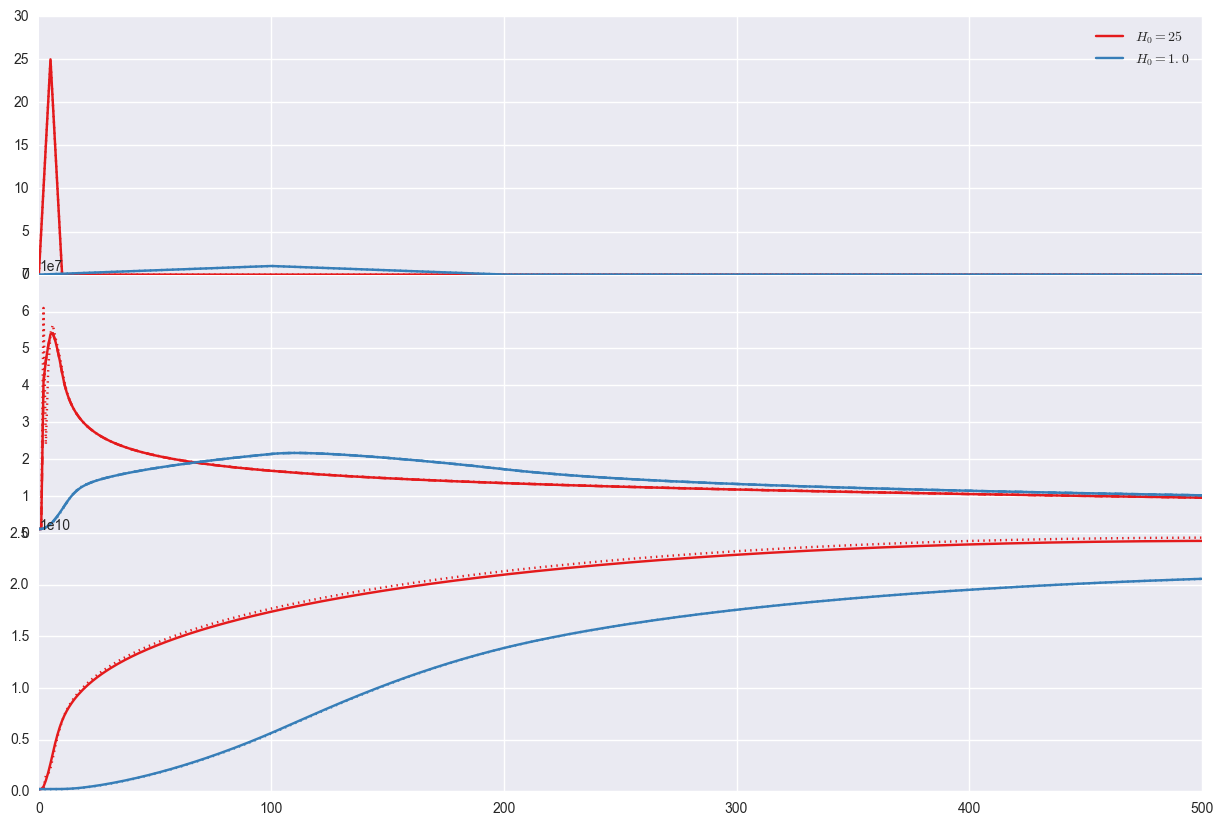

In [264]:
fig,axes = plt.subplots(3,1,figsize=(15,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for param,res_cpp,res_idl,col in zip(event_parameters,results_cpp,results_idl,colors):
    # CPP
    axes[1].plot(res_cpp.time,res_cpp.Te,color=col,ls='-')
    axes[1].plot(res_cpp.time,res_cpp.Ti,color=col,ls='--')
    axes[2].plot(res_cpp.time,res_cpp.n,color=col)
    axes[0].plot(res_cpp.time,res_cpp.h,color=col,label=r'$H_0={}$'.format(param['magnitude']))
    # IDL
    axes[0].plot(res_idl.time,res_idl.h,color=col,ls=':')
    axes[1].plot(res_idl.time,res_idl.Te,color=col,ls=':')
    axes[2].plot(res_idl.time,res_idl.n,color=col,ls=':')
axes[0].set_xlim([0.1,500])#base_config['total_time']])
#ax.set_ylim([0,1e7])
#axes[0].set_xscale('log')
#axes[0].set_yscale('log')
axes[0].legend(loc=1)